In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sophuspy as sp
import time

In [8]:
def find_feature_matches(img1, img2):
    orb= cv2.ORB_create()

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    print(keypoints1)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    min_dist, max_dist = float('inf'), float('-inf')
    for m in matches:
        dist = m.distance
        if dist > max_dist:
            max_dist = dist
        if dist < min_dist:
            min_dist = dist
    print(f'max_dist: {max_dist}')
    print(f'min_dist: {min_dist}')
    
    good_matches = []
    for m in matches:
        if m.distance <= max(2 * min_dist, 30.0):
            good_matches.append(m)
            
    print(f'good_matches: {len(good_matches)}')    
     
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img_matches)

    return keypoints1, keypoints2, good_matches

In [9]:
def pixel2cam(p, K):
    return (np.linalg.inv(K) @ p)[:2]

In [10]:
def get2d3dpts(keypoints1, keypoints2, good_matches, img1_depth, K):
    pts2, pts3d = [], []
    for m in good_matches:
        pt1 = keypoints1[m.queryIdx].pt
        pt2d = pixel2cam(np.array([[pt1[0]], [pt1[1]], [1]]), K)
        pt2 = keypoints2[m.trainIdx].pt
        d = img1_depth[int(pt1[1]), int(pt1[0])] / 5000.
        if d == 0:
            continue
        pt2d *= d
        pt3d = np.array([pt2d[0], pt2d[1], [d]])
        pts3d.append(pt3d)
        pts2.append([[int(pt2[0])], [int(pt2[1])]])
    return pts2, pts3d    

In [11]:
def BundleAdjustmentGaussNewton(pts3d, pts2, K, pose):
    iteration = 10
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    last_cost = 0
    start_time = time.time()
    for i in range(iteration):
        H = np.zeros((6, 6), dtype=np.float64)
        g = np.zeros((6, 1), dtype=np.float64)
        cost = 0
        for j in range(len(pts3d)):
            pt3d = pose * pts3d[j]   
            pt1 = np.array([[fx * pt3d[0] / pt3d[2] + cx], [fy * pt3d[1] / pt3d[2] + cy]])
            e = pts2[j] - pt1
            cost += np.linalg.norm(e)
            J = np.zeros((2, 6), dtype=np.float64)
            z_inv = 1 / pt3d[2]
            z_inv2 = 1 / pt3d[2] ** 2
            J[0, 0] = -fx * z_inv
            J[0, 1] = 0
            J[0, 2] = fx * pt3d[0] * z_inv2
            J[0, 3] = fx * pt3d[0] * pt3d[1] * z_inv2
            J[0, 4] = -fx + fx * pt3d[0] ** 2 * z_inv2
            J[0, 5] = fx * pt3d[1] * z_inv
            J[1, 0] = 0
            J[1, 1] = -fy * z_inv
            J[1, 2] = fy * pt3d[1] * z_inv2
            J[1, 3] = fy + fy * pt3d[1] ** 2 * z_inv2
            J[1, 4] = -fy * pt3d[0] * pt3d[1] * z_inv2
            J[1, 5] = -fy * pt3d[0] * z_inv
            J = J.T
            H += J @ J.T
            g += -J @ e
        if i > 0 and cost > last_cost:
            break
        dpose = np.linalg.inv(H) @ g    
        pose = sp.SE3.exp(dpose) * pose
        print(f'cost: {cost}')
        print(f'iteration: {i}')
        last_cost = cost
        if np.linalg.norm(dpose) < 1e-6:
            break
    end_time = time.time()
    print(f'duration: {end_time - start_time}')
    return pose
                   


(< cv2.KeyPoint 0x7f82b3f44cc0>, < cv2.KeyPoint 0x7f82b3f44540>, < cv2.KeyPoint 0x7f82b3f442a0>, < cv2.KeyPoint 0x7f82b3f444b0>, < cv2.KeyPoint 0x7f82b3f44060>, < cv2.KeyPoint 0x7f82b3f44b40>, < cv2.KeyPoint 0x7f82b3f44270>, < cv2.KeyPoint 0x7f82b3f44480>, < cv2.KeyPoint 0x7f82b3f44c00>, < cv2.KeyPoint 0x7f82b3f445d0>, < cv2.KeyPoint 0x7f82b3f442d0>, < cv2.KeyPoint 0x7f83480eab40>, < cv2.KeyPoint 0x7f83480eac30>, < cv2.KeyPoint 0x7f83480eac90>, < cv2.KeyPoint 0x7f83480ea780>, < cv2.KeyPoint 0x7f82b3f6d120>, < cv2.KeyPoint 0x7f82b3f6d570>, < cv2.KeyPoint 0x7f82b3f6d330>, < cv2.KeyPoint 0x7f82b3f6d5d0>, < cv2.KeyPoint 0x7f82b3f6d7b0>, < cv2.KeyPoint 0x7f82b3f6d720>, < cv2.KeyPoint 0x7f82b3f6d210>, < cv2.KeyPoint 0x7f82b3f6d0f0>, < cv2.KeyPoint 0x7f82b3f6d2d0>, < cv2.KeyPoint 0x7f82b3f6d1e0>, < cv2.KeyPoint 0x7f82b3f6d150>, < cv2.KeyPoint 0x7f82b3f6d060>, < cv2.KeyPoint 0x7f82b3f6d930>, < cv2.KeyPoint 0x7f82b3f6d090>, < cv2.KeyPoint 0x7f82b3f6d2a0>, < cv2.KeyPoint 0x7f82b3f6dcc0>, < cv2.K

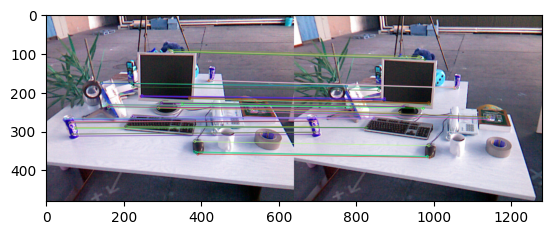

In [12]:
img1 = cv2.imread('../../images/1.png')
img2 = cv2.imread('../../images/2.png')
img1_depth = cv2.imread('../../images/1_depth.png', cv2.IMREAD_UNCHANGED)
K = np.array([[520.9, 0, 325.1],
              [0, 521.0, 249.7],
              [0, 0, 1]], dtype = np.float64)
pose = sp.SE3()

keypoints1, keypoints2, good_matches = find_feature_matches(img1, img2)
pts2, pts3d = get2d3dpts(keypoints1, keypoints2, good_matches, img1_depth, K)

pose = BundleAdjustmentGaussNewton(pts3d, pts2, K, pose)
print(pose)
